<a href="https://colab.research.google.com/github/sujitojha1/EVA4/blob/rev5/S12/EVA4_S12_Solution_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement EVA 4, Session11 : CIFAR 10

**Target**: 


*  Write a code that draws this curve (without the arrows). In submission, you'll upload your drawn curve and code for that
    * 11s11.png 

  5. What is your test accuracy?

**Results**

*  Total Parameters = 6,573,120
*  After 24 Epochs, Final Train Accuracy = 95.75%
*  After 24 Epochs, Final Test Accuracy = 90.27%

**Analysis**

*  Target accuracy > 90% using Reset18 new architecture. Model performance is slightly overfitting.

## 1. Loading Module and Models 

In [1]:
# Load modules/models from EVA course
!rm -rf EVA4
!git clone -b rev5 https://github.com/sujitojha1/EVA4 -q --quiet
print("Loaded EVA4 Modules")

# For inline matplotlib plotting
%matplotlib inline

Loaded EVA4 Modules


In [2]:
%%sh 
chmod u+r+x ./EVA4/S12/load_data_and_modules.sh
./EVA4/S12/load_data_and_modules.sh

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




## 2. Loading train and test data with transforms and loader functions

In [3]:
from EVA4.Modules import *

# Loading test and train data & dataloader
tiny_imagenet = dataset_tiny_imagenet(batch_size=512)

# Train dataloader
trainloader = tiny_imagenet.loader(train_flag=True)

# Test dataloader
testloader = tiny_imagenet.loader(train_flag=False)

classes = tiny_imagenet.classes

  pip install torch-lr-finder -v --global-option="amp"


CUDA availability ? True


## 3. Exploratory Data Analysis

### 3.1 Summary Statistics

In [0]:
#tiny_imagenet.data_summary_stats()
#print(vars(train))

### 3.2 Plotting sample images

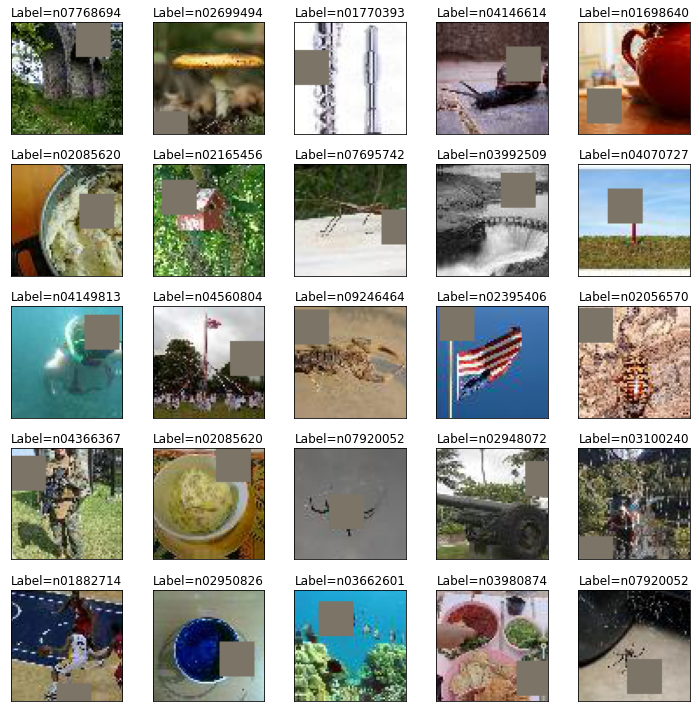

In [4]:
tiny_imagenet.sample_pictures(train_flag=True)

# The Model

In [5]:
from EVA4.Models import *

# Loading ResNet18 Model
net = ResNet_tiny_imagenet()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


# Model Summary

In [6]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]          73,728
         MaxPool2d-5          [-1, 128, 32, 32]               0
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,456
       BatchNorm2d-9          [-1, 128, 32, 32]             256
           Conv2d-10          [-1, 128, 32, 32]         147,456
      BatchNorm2d-11          [-1, 128, 32, 32]             256
         ResBlock-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         294,912
        MaxPool2d-14          [-1, 256,

# Define a Loss function and optimizer

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


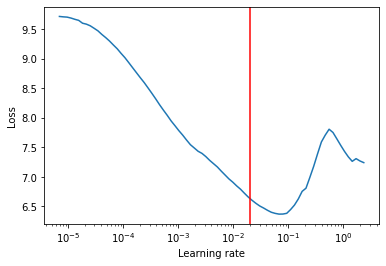

In [7]:
from EVA4.Modules import LRFinder
import torch.optim as optim

model = net
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.02) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [0]:
# import torch.optim as optim
# model = net
# criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.10, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.1, 
                                          steps_per_epoch=143, 
                                          pct_start=0.20, 
                                          epochs=50,
                                          div_factor=100.0, 
                                          anneal_strategy='linear',
                                          base_momentum=0.8)

# Training and Testing

In [9]:
# Load train and test model
from EVA4.Modules import *

train = train()
test = test()

for epoch in range(50):  # loop over the dataset multiple times

    train.execute(net, device, trainloader, optimizer, criterion, epoch,scheduler)
    test.execute(net, device, testloader, criterion)

print('Finished Training')

  0%|          | 0/143 [00:00<?, ?it/s]


Epoch: 0


  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 2624/37000 (7.09%)


Epoch: 1


  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 4650/37000 (12.57%)


Epoch: 2


Loss=4.0954 Batch_id=142 LR=0.0320 Accuracy=16.04: 100%|██████████| 143/143 [05:25<00:00,  2.27s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 6873/37000 (18.58%)


Epoch: 3


Loss=3.4770 Batch_id=142 LR=0.0414 Accuracy=21.49: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 7381/37000 (19.95%)


Epoch: 4


Loss=3.1028 Batch_id=142 LR=0.0507 Accuracy=25.92: 100%|██████████| 143/143 [05:29<00:00,  2.30s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 9099/37000 (24.59%)


Epoch: 5


Loss=2.8953 Batch_id=142 LR=0.0601 Accuracy=30.19: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 10853/37000 (29.33%)


Epoch: 6


Loss=2.7686 Batch_id=142 LR=0.0694 Accuracy=33.74: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 12504/37000 (33.79%)


Epoch: 7


Loss=2.5177 Batch_id=142 LR=0.0788 Accuracy=37.62: 100%|██████████| 143/143 [05:25<00:00,  2.27s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 13251/37000 (35.81%)


Epoch: 8


Loss=2.5527 Batch_id=142 LR=0.0881 Accuracy=41.00: 100%|██████████| 143/143 [05:30<00:00,  2.31s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 13427/37000 (36.29%)


Epoch: 9


Loss=2.4602 Batch_id=142 LR=0.0975 Accuracy=43.25: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 12950/37000 (35.00%)


Epoch: 10


Loss=2.2561 Batch_id=142 LR=0.0982 Accuracy=46.42: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 14670/37000 (39.65%)


Epoch: 11


Loss=2.1092 Batch_id=142 LR=0.0958 Accuracy=48.89: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 15225/37000 (41.15%)


Epoch: 12


Loss=1.8655 Batch_id=142 LR=0.0934 Accuracy=51.71: 100%|██████████| 143/143 [05:30<00:00,  2.31s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 15381/37000 (41.57%)


Epoch: 13


Loss=1.8918 Batch_id=142 LR=0.0909 Accuracy=54.26: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 16452/37000 (44.46%)


Epoch: 14


Loss=1.7673 Batch_id=142 LR=0.0885 Accuracy=56.73: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 15907/37000 (42.99%)


Epoch: 15


Loss=1.5325 Batch_id=142 LR=0.0861 Accuracy=58.38: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 16456/37000 (44.48%)


Epoch: 16


Loss=1.5793 Batch_id=142 LR=0.0836 Accuracy=60.68: 100%|██████████| 143/143 [05:30<00:00,  2.31s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 17003/37000 (45.95%)


Epoch: 17


Loss=1.4846 Batch_id=142 LR=0.0812 Accuracy=63.08: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 16686/37000 (45.10%)


Epoch: 18


Loss=1.1151 Batch_id=142 LR=0.0788 Accuracy=65.18: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 16167/37000 (43.69%)


Epoch: 19


Loss=1.3209 Batch_id=142 LR=0.0763 Accuracy=66.93: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 17487/37000 (47.26%)


Epoch: 20


Loss=1.2215 Batch_id=142 LR=0.0739 Accuracy=69.66: 100%|██████████| 143/143 [05:30<00:00,  2.31s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 17191/37000 (46.46%)


Epoch: 21


Loss=1.1961 Batch_id=142 LR=0.0715 Accuracy=71.63: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 16803/37000 (45.41%)


Epoch: 22


Loss=0.8420 Batch_id=142 LR=0.0690 Accuracy=73.62: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 17158/37000 (46.37%)


Epoch: 23


Loss=0.9011 Batch_id=142 LR=0.0666 Accuracy=76.09: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 16757/37000 (45.29%)


Epoch: 24


Loss=0.8293 Batch_id=142 LR=0.0642 Accuracy=77.73: 100%|██████████| 143/143 [05:30<00:00,  2.31s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 17126/37000 (46.29%)


Epoch: 25


Loss=0.8018 Batch_id=142 LR=0.0618 Accuracy=80.47: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 17590/37000 (47.54%)


Epoch: 26


Loss=0.7187 Batch_id=142 LR=0.0593 Accuracy=82.37: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 17339/37000 (46.86%)


Epoch: 27


Loss=0.4768 Batch_id=142 LR=0.0569 Accuracy=84.29: 100%|██████████| 143/143 [05:26<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 17402/37000 (47.03%)


Epoch: 28


Loss=0.5662 Batch_id=142 LR=0.0545 Accuracy=85.85: 100%|██████████| 143/143 [05:30<00:00,  2.31s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 17462/37000 (47.19%)


Epoch: 29


Loss=0.4133 Batch_id=142 LR=0.0520 Accuracy=87.14: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 17577/37000 (47.51%)


Epoch: 30


Loss=0.3765 Batch_id=142 LR=0.0496 Accuracy=88.71: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 17459/37000 (47.19%)


Epoch: 31


Loss=0.4059 Batch_id=142 LR=0.0472 Accuracy=90.02: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 17680/37000 (47.78%)


Epoch: 32


Loss=0.3265 Batch_id=142 LR=0.0447 Accuracy=90.88: 100%|██████████| 143/143 [05:30<00:00,  2.31s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 17838/37000 (48.21%)


Epoch: 33


Loss=0.3191 Batch_id=142 LR=0.0423 Accuracy=92.15: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 18135/37000 (49.01%)


Epoch: 34


Loss=0.2697 Batch_id=142 LR=0.0399 Accuracy=93.12: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 18216/37000 (49.23%)


Epoch: 35


Loss=0.2034 Batch_id=142 LR=0.0374 Accuracy=94.11: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 18001/37000 (48.65%)


Epoch: 36


Loss=0.1806 Batch_id=142 LR=0.0350 Accuracy=94.67: 100%|██████████| 143/143 [05:30<00:00,  2.31s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 18333/37000 (49.55%)


Epoch: 37


Loss=0.1688 Batch_id=142 LR=0.0326 Accuracy=95.34: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 18270/37000 (49.38%)


Epoch: 38


Loss=0.1897 Batch_id=142 LR=0.0301 Accuracy=95.86: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 18136/37000 (49.02%)


Epoch: 39


Loss=0.1731 Batch_id=142 LR=0.0277 Accuracy=96.58: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 18643/37000 (50.39%)


Epoch: 40


Loss=0.1724 Batch_id=142 LR=0.0253 Accuracy=96.91: 100%|██████████| 143/143 [05:30<00:00,  2.31s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 18592/37000 (50.25%)


Epoch: 41


Loss=0.1057 Batch_id=142 LR=0.0228 Accuracy=97.42: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 18690/37000 (50.51%)


Epoch: 42


Loss=0.1040 Batch_id=142 LR=0.0204 Accuracy=97.74: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 18696/37000 (50.53%)


Epoch: 43


Loss=0.0618 Batch_id=142 LR=0.0180 Accuracy=97.83: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 18882/37000 (51.03%)


Epoch: 44


Loss=0.0774 Batch_id=142 LR=0.0155 Accuracy=98.24: 100%|██████████| 143/143 [05:30<00:00,  2.31s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 18824/37000 (50.88%)


Epoch: 45


Loss=0.0491 Batch_id=142 LR=0.0131 Accuracy=98.46: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 18939/37000 (51.19%)


Epoch: 46


Loss=0.0525 Batch_id=142 LR=0.0107 Accuracy=98.67: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 19039/37000 (51.46%)


Epoch: 47


Loss=0.0840 Batch_id=142 LR=0.0082 Accuracy=98.79: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 19132/37000 (51.71%)


Epoch: 48


Loss=0.0497 Batch_id=142 LR=0.0058 Accuracy=98.96: 100%|██████████| 143/143 [05:30<00:00,  2.31s/it]
  0%|          | 0/143 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 19164/37000 (51.79%)


Epoch: 49


Loss=0.0457 Batch_id=142 LR=0.0034 Accuracy=99.13: 100%|██████████| 143/143 [05:25<00:00,  2.28s/it]



Test set: Average loss: 0.0058, Accuracy: 19186/37000 (51.85%)

Finished Training


# Misclassified images


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


RuntimeError: ignored

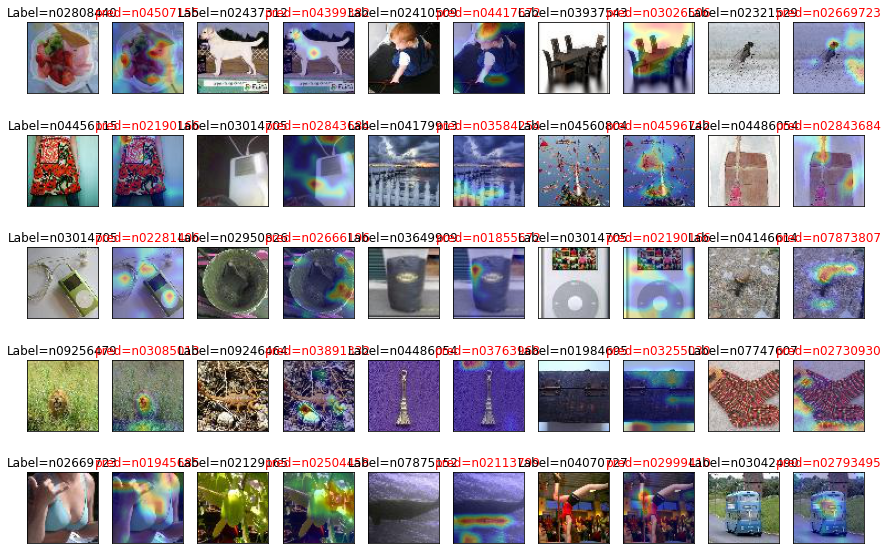

In [10]:
plot_misclassified_images_w_gradcam(net,device,testloader,classes)

# Plotting Train & Test Accuracy/Losses

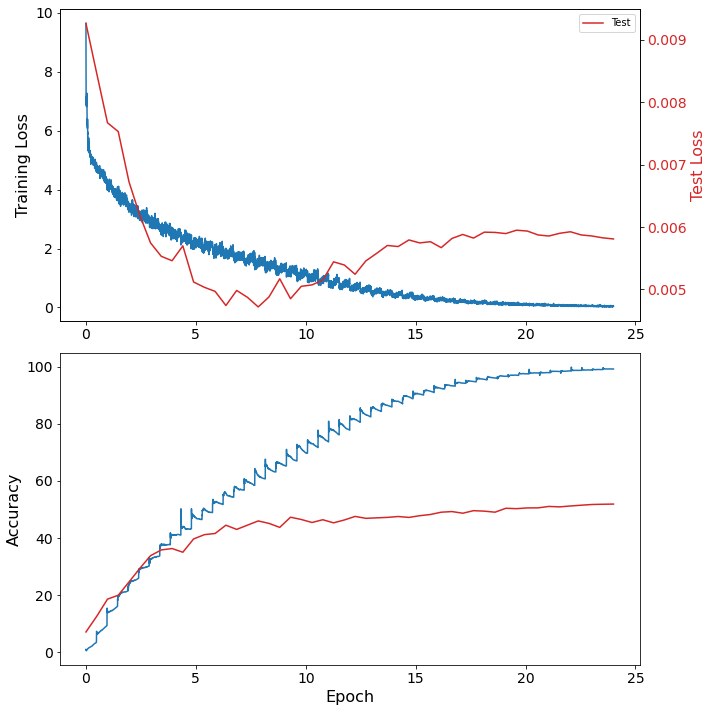

In [11]:
plot_train_test_acc_loss(train,test)